In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.submodular_pick import SubmodularPick

from collections import defaultdict

import re

import math

### Loading the data and creating training and testing data

In [2]:
class_names = ['alt.atheism', 'soc.religion.christian']
categories = [name.split('.')[-1].capitalize() for name in class_names]

X_train, y_train = fetch_20newsgroups(subset='train', categories=class_names, return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', categories=class_names, return_X_y=True)

### Creating a black box model and getting probabilistic outputs

In [3]:
black_box_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
black_box_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [4]:
print(f"Model Accuracy: {black_box_model.score(X_test, y_test):.2f}")

Model Accuracy: 0.85


### Picking instances to replicate (x) and creating perturbations around it (z')

In [5]:
def perturb_matrix(instance_index,num_samples):

    #Creating the instance from the test set
    instance=X_test[instance_index]
    true_label=y_test[instance_index]

    # Generating model predictions for this instance:
    model_pred=black_box_model.predict_proba([instance])
    
    #print(f"Model prediction for {instance_index} is {model_pred}")

    #Creating the perturbation matrix
    words = re.findall(r'\b\w+\b', instance.lower())
    num_words=len(words)

    perturb=np.random.randint(0,2,size=(num_samples, num_words))
    perturb[0,:] = 1 #setting the first row as the original instance for easy comparison

    return perturb, words
    


### Generating predictions for the perturbations

In [6]:
def perturb_predictions(perturb, words):

    #Reconstructing the sentences from the matrix:
    perturb_texts = []
    for row in perturb:
        temp_text = ' '.join([word for word, present in zip(words, row) if present])
        perturb_texts.append(temp_text)   
    
    perturb_preds = black_box_model.predict_proba(perturb_texts)

    return perturb_preds

### Calculating the proximity (πx(z)) using cosine distance

We're using cosine distance since it is better for texts

In [7]:
def proximity(perturb, words):
    distances=cosine_distances(perturb[0].reshape(1,-1), perturb).ravel()

    #Calculating proximity:
    num_words=len(words)
    kernel_width= 0.75*np.sqrt(num_words)

    prox=np.exp(-(distances**2)/(kernel_width **2))

    return prox

### Creating a visualisation

In [8]:
def visual(simple_model, words, instance_index, true_label_name, predicted_label_name, confidence_score):

    coefs=simple_model.coef_
    feature_weights = defaultdict(float)
    for word, coef in zip(words, coefs):
        feature_weights[word] += coef

    #Finding the most important features:
    sort = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)
    top=sort[:8]
    top.sort(key=lambda x: x[1])

    words_plot=[x[0] for x in top]
    weights_plot = [x[1] for x in top]

    #Plotting:
    colours=['green' if w>0 else 'indianred' for w in weights_plot]

    fig, ax=plt.subplots(figsize=(10,6))
    ax.barh(np.arange(len(words_plot)), weights_plot, color=colours)
            
    title = (f"Instance #{instance_index}\n"
             f"Predicted: '{predicted_label_name}' (Confidence: {confidence_score:.2%})\n"
             f"True Class: '{true_label_name}'")
    ax.set_title(title, fontsize=14)
    
    ax.set_yticks(np.arange(len(words_plot)))
    ax.set_yticklabels(words_plot, fontsize=12)
    ax.set_xlabel("Contribution towards 'Christian' prediction", fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    
    plt.tight_layout()

    #plt.savefig(f'instance_{instance_index}_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()
    

### Training a simple local interpretable model (g)

In [9]:
def training_g(instance_index, num_samples, black_box_model, class_to_explain=1):

    perturb, words = perturb_matrix(instance_index, num_samples)
    X_local = perturb

    all_class_predictions = perturb_predictions(perturb, words)

    y_local = all_class_predictions[:, class_to_explain]

    weights = proximity(perturb, words)

    simple_model = Ridge(alpha=1, fit_intercept=True)
    simple_model.fit(X_local, y_local, sample_weight=weights)

    class_names = categories

    original_instance_text = X_test[instance_index]
    prediction_probs = black_box_model.predict_proba([original_instance_text])[0]
    predicted_label_idx = np.argmax(prediction_probs)
    predicted_label_name = class_names[predicted_label_idx]
    confidence_score = prediction_probs[predicted_label_idx]

    true_label_idx = y_test[instance_index]
    true_label_name = class_names[true_label_idx]

    return visual(simple_model, words, instance_index, true_label_name, predicted_label_name, confidence_score)

# Validation

Here we pull in LIME to validate the LIME-replication pipeline I have created. To thoroughly investigate this, I will start by picking three instances to validate; correctly classified, misclassified and edge-case instances.

### double check this sentence structure lol

### Selecting instances

In [10]:

predicted_labels = black_box_model.predict(X_test)
predicted_probs = black_box_model.predict_proba(X_test)


# Case 1: A correctly classified instance where the model was most confident
correct_indices = np.where(predicted_labels == y_test)[0]
correct_confidences = np.max(predicted_probs[correct_indices], axis=1)
most_confident_correct_idx_in_subset = np.argmax(correct_confidences)
correct_confident_idx = correct_indices[most_confident_correct_idx_in_subset]


# Case 2: A misclassified instance where the model was most confident in its mistake
misclassified_indices = np.where(predicted_labels != y_test)[0]
misclassified_confidences = np.max(predicted_probs[misclassified_indices], axis=1)
most_confident_misclassified_idx_in_subset = np.argmax(misclassified_confidences)
misclassified_confident_idx = misclassified_indices[most_confident_misclassified_idx_in_subset]


# Case 3: The "edge case" where the model was least confident (closest to 50/50)
confidence_diffs = np.abs(predicted_probs[:, 0] - predicted_probs[:, 1])
edge_case_idx = np.argmin(confidence_diffs)

print("--- Selected Instances for Validation ---")
print(f"Correctly Classified Instance Index: {correct_confident_idx}")
print(f"Misclassified Instance Index: {misclassified_confident_idx}")
print(f"Edge Case Instance Index: {edge_case_idx}")

--- Selected Instances for Validation ---
Correctly Classified Instance Index: 599
Misclassified Instance Index: 610
Edge Case Instance Index: 603


### Validating with LIME

In [11]:
explainer = LimeTextExplainer(class_names=class_names)
predictor_fn = black_box_model.predict_proba

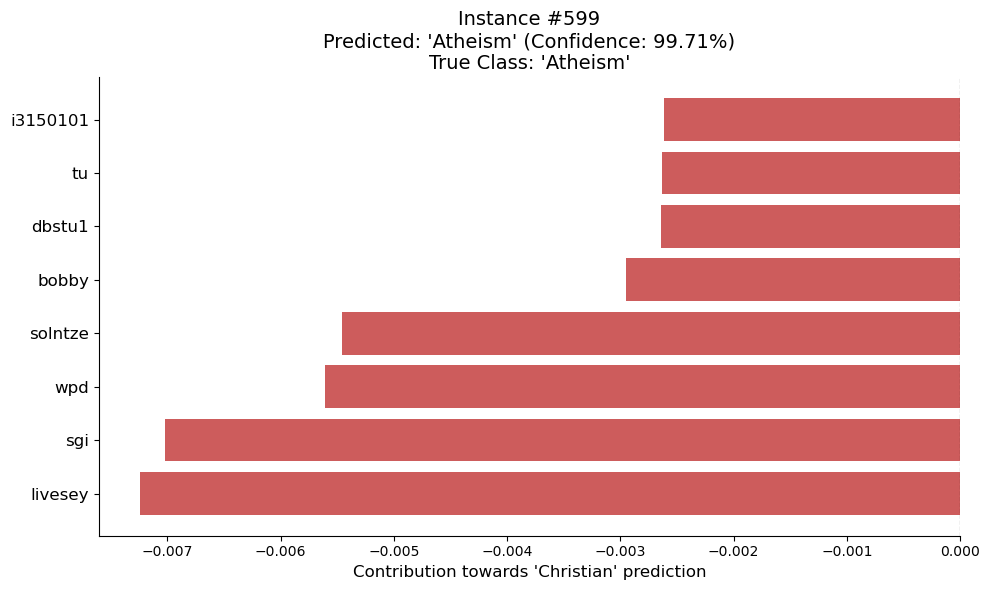

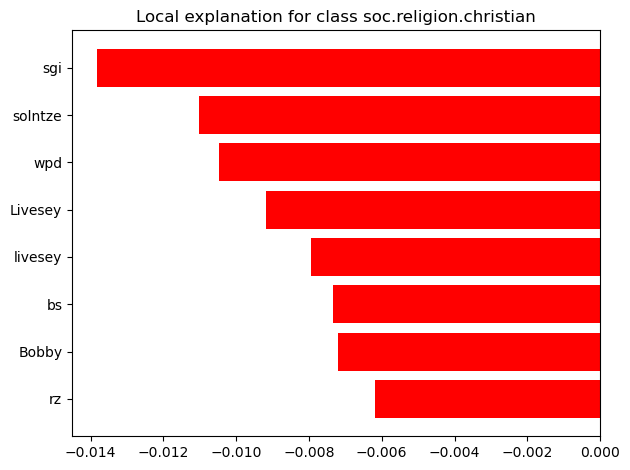

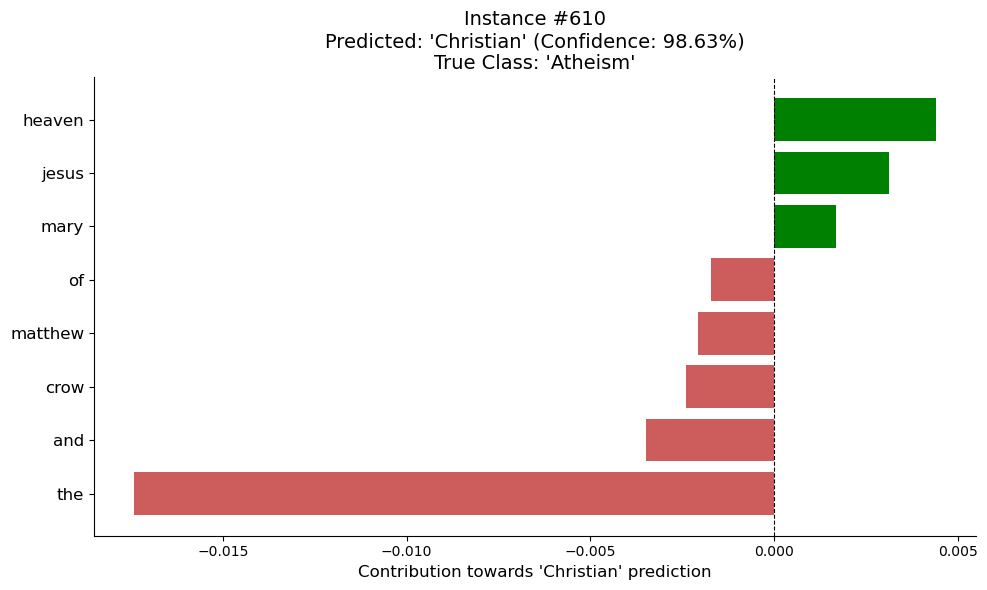

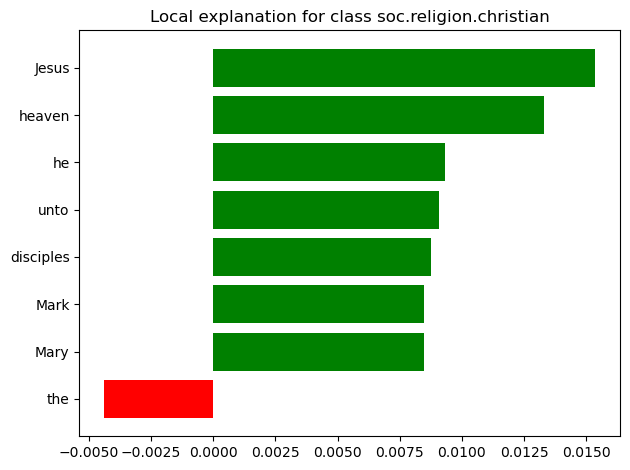

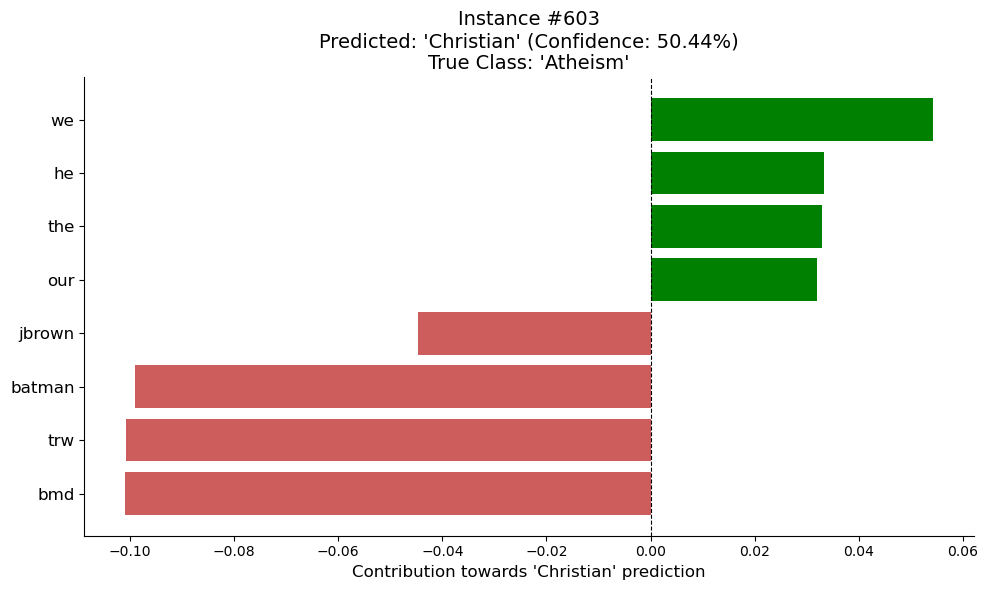

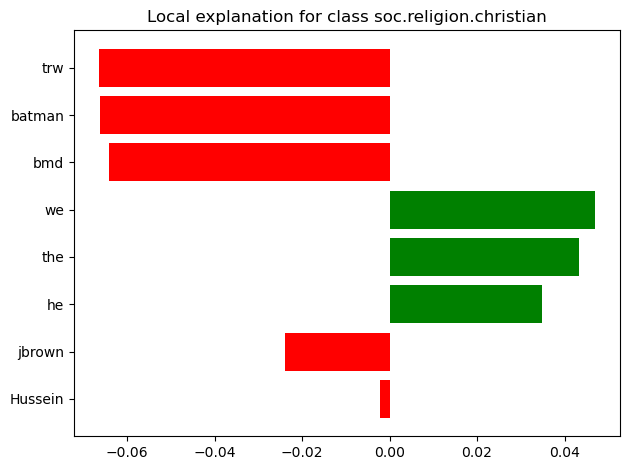

In [12]:

val_instances=[correct_confident_idx, misclassified_confident_idx, edge_case_idx]

for i in val_instances:
    instance_text=X_test[i]  
    training_g(i, 5000, black_box_model, class_to_explain=1)

    explanation = explainer.explain_instance(
        instance_text,
        predictor_fn,
        num_features=8
    )

    
    fig=explanation.as_pyplot_figure()
    plt.tight_layout()
    #plt.savefig(f'LIME instance_{i}_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()



# Replicating SP-LIME

Creating a leaner version of the *training_g* function to generate weights.

In [13]:
def generate_explanation(instance_index, num_samples, black_box_model, class_to_explain=1):

    perturb, words_in_instance = perturb_matrix(instance_index, num_samples)
    X_local = perturb

    all_class_predictions = perturb_predictions(perturb, words_in_instance)

    y_local = all_class_predictions[:, class_to_explain]

    weights = proximity(perturb, words_in_instance)

    simple_model = Ridge(alpha=1, fit_intercept=True)
    simple_model.fit(X_local, y_local, sample_weight=weights)

    return simple_model, words_in_instance

In [14]:
def imp_matrix_function(X_test, num_instances_to_explain):

    subset_indices = np.random.choice(len(X_test), num_instances_to_explain, replace=False)
    X_subset = [X_test[i] for i in subset_indices]    
    n_rows = len(X_subset)

    all_words=set()
    for i in X_subset:
        words = re.findall(r'\b\w+\b', i.lower())
        all_words.update(words)
    vocab=list(all_words)
    vocab_map={word:i for i, word in enumerate(vocab)}
    n_cols = len(vocab)

    #creating the matrix

    imp_matrix=np.zeros((n_rows,n_cols)) 
    for i, instance_idx in enumerate(subset_indices):
          simple_model, words_in_instance = generate_explanation(instance_idx, 500, black_box_model, 1)          
          explanation = dict(zip(words_in_instance, simple_model.coef_))

          for word, weight in explanation.items():
              if word in vocab_map:
                  col_idx = vocab_map[word]
                  imp_matrix[i, col_idx] = weight

    return imp_matrix, subset_indices
        
        

In [15]:
def submodular_pick(imp_matrix, k):
    picked=[]
    dim=imp_matrix.shape
    num_instances, num_features=dim
    coverage=np.zeros(num_features) 
    for i in range(k):
        best_gain=-1
        best_cand_index=-1

        for j in range(num_instances):
            if j in picked:
                continue
            else:
                cand_weight=np.abs(imp_matrix[j])
                marginal_gain=np.maximum(0, cand_weight-coverage)
                current_gain=np.sum(marginal_gain)

                if current_gain>best_gain:
                    best_gain=current_gain
                    best_cand_index=j

        if best_cand_index!=-1:
            picked.append(best_cand_index)
            picked_weights =np.abs(imp_matrix[best_cand_index])
            coverage=np.maximum(coverage,picked_weights)

    return picked
        

In [20]:
def sp_visual(picked, subset_indices, X_test, y_test, black_box_model, class_names, num_samples=500):
    k=6
    ncols = 2
    nrows = math.ceil(k / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 5.5))
    axes = axes.flatten()

    for i, pick in enumerate(picked):
        ax = axes[i]
        original_instance_index = subset_indices[pick]

        simple_model, words = generate_explanation(original_instance_index, num_samples, black_box_model, class_to_explain=1)
        
        original_text = X_test[original_instance_index]
        prediction_probs = black_box_model.predict_proba([original_text])[0]
        predicted_label_idx = np.argmax(prediction_probs)
        predicted_label = class_names[predicted_label_idx]
        confidence_score = prediction_probs[predicted_label_idx]
        true_label_idx = y_test[original_instance_index]
        true_label = class_names[true_label_idx]

        num_features = 8 
        weights = simple_model.coef_
        
        feature_weights = defaultdict(float)
        for word, weight in zip(words, weights):
            feature_weights[word] += weight
        
        sorted_features = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_features[:num_features]
        top_features.sort(key=lambda x: x[1])

        words_to_plot = [x[0] for x in top_features]
        weights_to_plot = [x[1] for x in top_features]
        
        colors = ['green' if w > 0 else 'indianred' for w in weights_to_plot]
        
        ax.barh(np.arange(len(words_to_plot)), weights_to_plot, color=colors)
        
        title = (f"Instance #{original_instance_index}\n"
                 f"Predicted: '{predicted_label}' (Conf: {confidence_score:.2%})\n"
                 f"True Class: '{true_label}'")
        ax.set_title(title, fontsize=10)
        
        ax.set_yticks(np.arange(len(words_to_plot)))
        ax.set_yticklabels(words_to_plot, fontsize=9)
        ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
    

    for i in range(len(picked), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle("SP-LIME: A Global Explanation of the Model", fontsize=22, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    #plt.savefig('sp_lime_global_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()

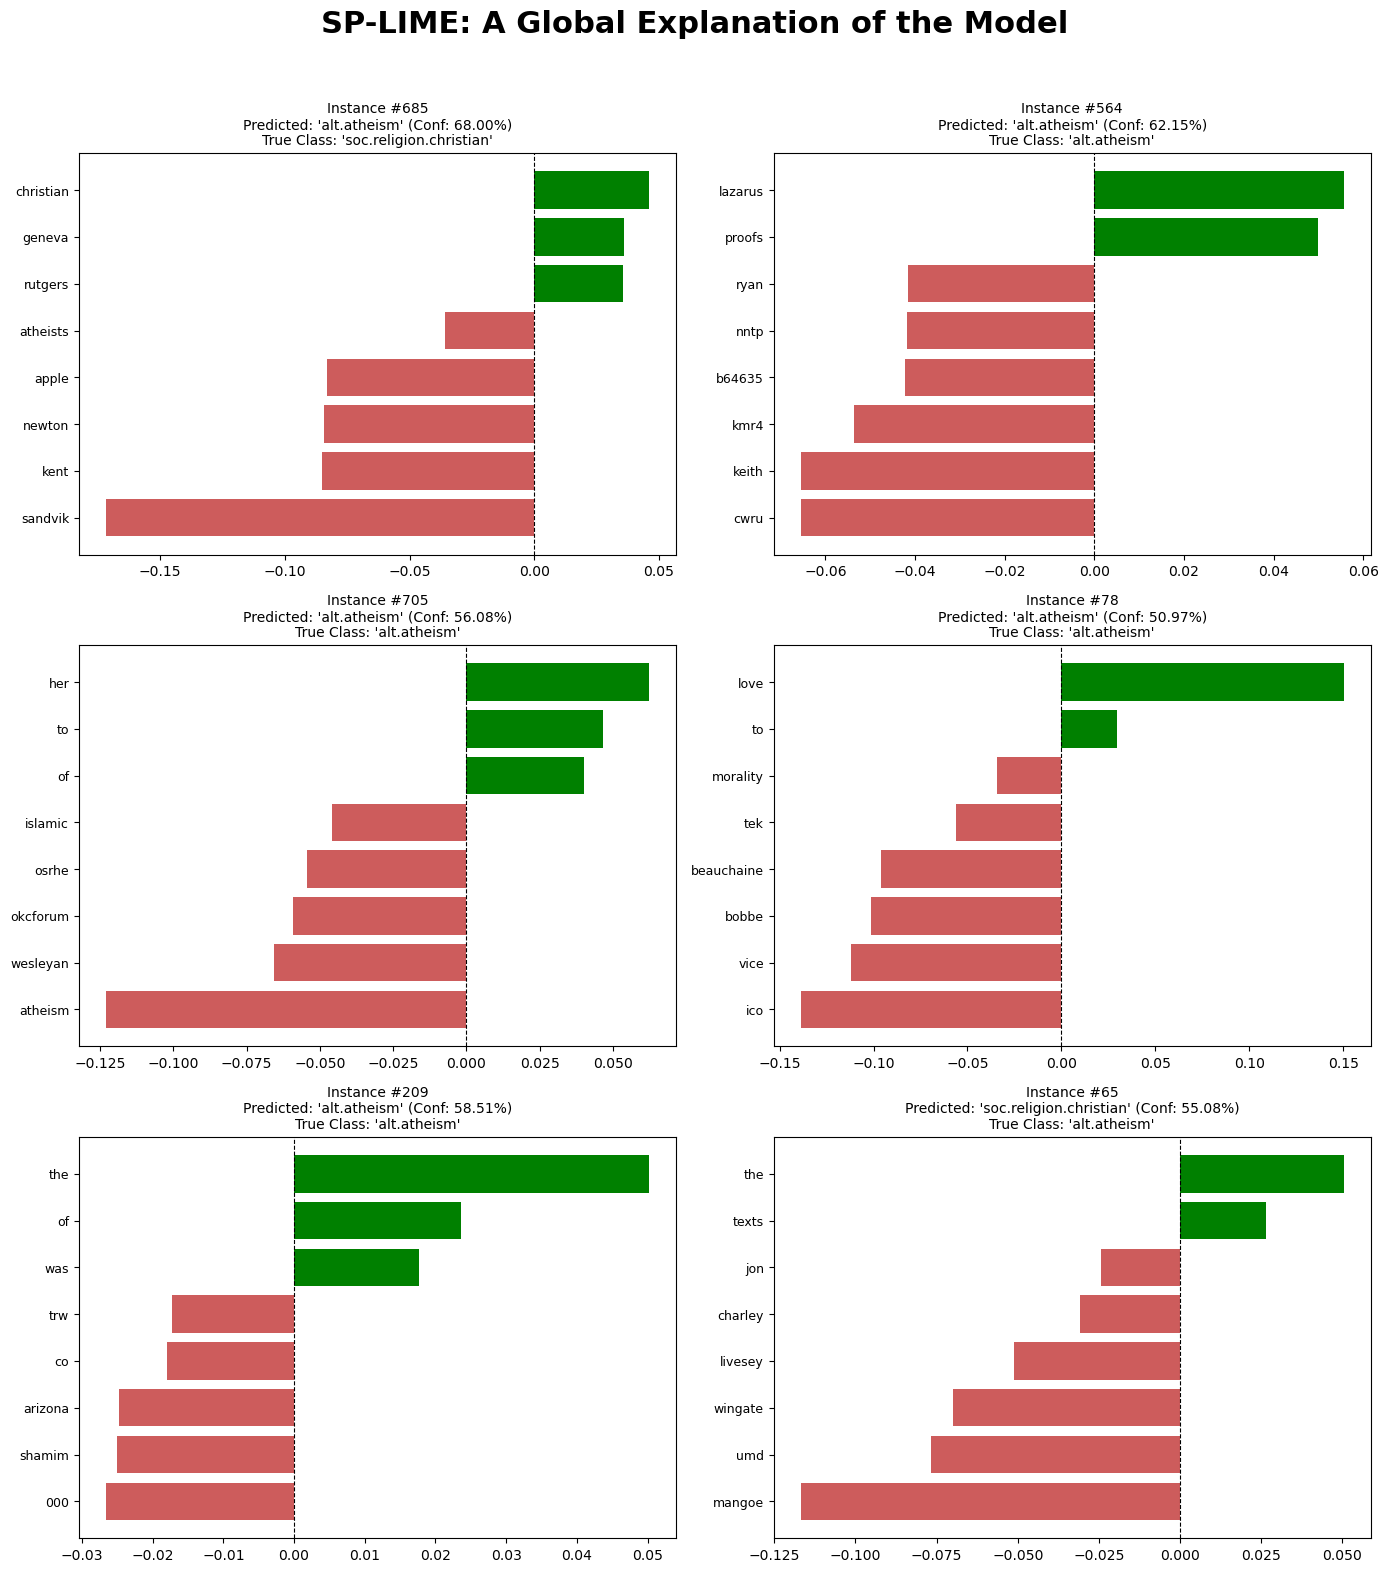

In [21]:
imp_matrix, subset_indices=imp_matrix_function(X_test, num_instances_to_explain=500)

picked=submodular_pick(imp_matrix, k=6)

sp_visual(picked, subset_indices, X_test, y_test, black_box_model, class_names, num_samples=500)      
    